In [1]:
import torch.nn as nn
import numpy as np
import torch
from PIL import Image
import torchvision.transforms as T
from torchvision.utils import save_image

import warnings
warnings.filterwarnings("ignore")

In [2]:
def apply_random_mask(img):
    """Randomly masks image"""
    y1, x1 = np.random.randint(0, 128 - 16, 2)
    y2, x2 = y1 + 16, x1 + 16
    masked_part = img[:, y1:y2, x1:x2]
    masked_img = img.clone()
    masked_img[:, y1:y2, x1:x2] = 1
    points = [y1, y2, x1, x2]

    return masked_img, masked_part, points

def reconstract_random_mask(img, mask, points):
    mask = mask / 2  + 0.5
    img = img / 2  + 0.5
    img[0, points[0]:points[1], points[2]:points[3]] = mask[0]
    img[1, points[0]:points[1], points[2]:points[3]] = mask[1]
    img[2, points[0]:points[1], points[2]:points[3]] = mask[2]
    return img

def apply_random_mask(img):
    """Randomly masks image"""
    y1, x1 = np.random.randint(0, 128 - 16, 2)
    y2, x2 = y1 + 16, x1 + 16
    masked_part = img[:, y1:y2, x1:x2]
    masked_img = img.clone()
    masked_img[:, y1:y2, x1:x2] = 1
    points = [y1, y2, x1, x2]

    return masked_img, masked_part, points

import matplotlib.pyplot as plt
def matplotlib_imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [3]:
class Generator(nn.Module):
    def __init__(self, channels=3):
        super(Generator, self).__init__()

        def encoder(in_feat, out_feat, normalize=True):
            layers = [nn.Conv2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2))
            return layers

        def decoder(in_feat, out_feat, normalize=True):
            layers = [nn.ConvTranspose2d(in_feat, out_feat, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.BatchNorm2d(out_feat, 0.8))
            layers.append(nn.ReLU())
            return layers

        self.model = nn.Sequential(
            *encoder(channels, 64, normalize=False),
            *encoder(64, 64),
            *encoder(64, 128),
            *encoder(128, 256),
            *encoder(256, 512),
            nn.Conv2d(512, 4000, 1),
            *decoder(4000, 512),
            *decoder(512, 256),
            *decoder(256, 128),
            *decoder(128, 64),
            nn.Conv2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32, 0.8),
            nn.ReLU(),
            nn.Conv2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16, 0.8),
            nn.Conv2d(16, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.model(x)
generator = Generator()

In [4]:
generator.load_state_dict(torch.load("saved_models/generator.pth"))

<All keys matched successfully>

In [5]:
img = Image.open("test.jpg")

In [6]:
img = img.resize((128,128), Image.ANTIALIAS)

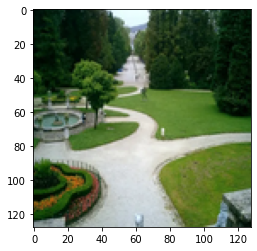

In [7]:
matplotlib_imshow(T.ToTensor()(img))

In [8]:
img_crop, mask, points = apply_random_mask(T.ToTensor()(img))

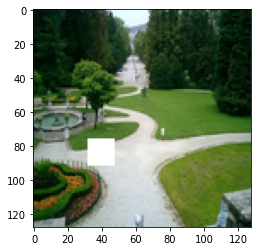

In [9]:
matplotlib_imshow(img_crop)

In [10]:
result = generator(img_crop[None, :])

[W NNPACK.cpp:79] Could not initialize NNPACK! Reason: Unsupported hardware.


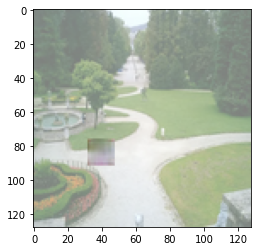

In [11]:
matplotlib_imshow(reconstract_random_mask(img_crop, result[0], points))

In [12]:
result_img = reconstract_random_mask(img_crop, result[0], points)

In [13]:
save_image(result_img, "reconstr1.jpg")